In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Library

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import json

from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Seed Config

In [3]:
def set_seed(seed: int = 42, deterministic: bool = False):
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)

    np.random.seed(seed)

    torch.cuda.manual_seed_all(seed)
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

# Dataloader

## Univariate Timeseries

### PD Dataset

In [4]:
class PDSegLoader:
    def __init__(self, data_path, win_size, step, mode="train"):

        self.mode = mode
        self.step= step
        self.win_size = win_size
        self.scaler = StandardScaler()

        fn = 'power_data.pkl'
        train_path = os.path.join(data_path + '-train', fn)
        test_path = os.path.join(data_path + '-test', fn)

        tr_df = pd.DataFrame(pd.read_pickle(open(train_path, 'rb')))
        te_df = pd.DataFrame(pd.read_pickle(open(test_path, 'rb')))

        train_data = tr_df[[0]].to_numpy()
        self.scaler.fit(train_data)
        data = self.scaler.transform(train_data)

        test_data = te_df[[0]].to_numpy()
        test_label = te_df[1].to_numpy().flatten()

        print(f"Raw train data shape: {train_data.shape}")
        print(f"Raw test data shape: {test_data.shape}")

        self.test = self.scaler.transform(test_data)
        self.train = data
        self.test_labels = test_label

        print(f"Processed train shape: {self.train.shape}")
        print(f"Processed test shape: {self.test.shape}")

    def __len__(self):
        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif self.mode == "test":
            return (self.test.shape[0] - self.win_size) // self.step + 1

    def __getitem__(self, index):
        index = index * self.step
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.zeros(self.win_size, dtype=np.float32)
        elif self.mode == "test":
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])

### UCR Dataset

In [5]:
class UCRSegLoader:
    def __init__(self, data_path, win_size, step, mode="train"):
        self.mode = mode
        self.step = step
        self.win_size = win_size
        self.scaler = StandardScaler()

        data = np.load(f"{data_path}/UCR_train.npy")
        print(f"Raw train data shape: {data.shape}")

        if data.ndim > 2:
            data = data.reshape(data.shape[0], -1)
        self.scaler.fit(data)
        data = self.scaler.transform(data)
        test_data = np.load(f"{data_path}/UCR_test.npy")
        print(f"Raw test data shape: {test_data.shape}")
        if test_data.ndim > 2:
            test_data = test_data.reshape(test_data.shape[0], -1)
        self.test = self.scaler.transform(test_data)
        self.train = data
        self.test_labels = np.load(f"{data_path}/UCR_test_label.npy")
        print(f"Processed train shape: {self.train.shape}")
        print(f"Processed test shape: {self.test.shape}")

    def __len__(self):
        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif self.mode == "test":
            return (self.test.shape[0] - self.win_size) // self.step + 1

    def __getitem__(self, index):
        index = index * self.step
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.zeros(self.win_size, dtype=np.float32)
        elif self.mode == "test":
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])

## Bivariate Timeseries

### ECG Dataset

In [6]:
class ECGSegLoader:
    def __init__(self, data_path, win_size, step, mode="train"):
        self.mode = mode
        self.step = step
        self.win_size = win_size
        self.scaler = StandardScaler()

        train_data = np.load(f"{data_path}/ECG_train.npy")
        print(f"Raw train data shape: {train_data.shape}")
        self.scaler.fit(train_data)
        self.train = self.scaler.transform(train_data)

        test_data = np.load(f"{data_path}/ECG_test.npy")
        print(f"Raw test data shape: {test_data.shape}")
        self.test = self.scaler.transform(test_data)

        self.test_labels = np.load(f"{data_path}/ECG_test_label.npy")
        print(f"Processed train shape: {self.train.shape}")
        print(f"Processed test shape: {self.test.shape}")

    def __len__(self):
        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif self.mode == "test":
            return (self.test.shape[0] - self.win_size) // self.step + 1

    def __getitem__(self, index):
        index = index * self.step
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.zeros(self.win_size, dtype=np.float32)
        elif self.mode == "test":
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])

### Gesture2D Dataset

In [7]:
class Gesture2DSegLoader:
    def __init__(self, data_path, win_size, step, mode="train"):
        self.mode = mode
        self.step = step
        self.win_size = win_size
        self.scaler = StandardScaler()

        data = np.load(f"{data_path}/2DGesture_train.npy")
        print(f"Raw train data shape: {data.shape}")
        self.scaler.fit(data)
        data = self.scaler.transform(data)

        test_data = np.load(f"{data_path}/2DGesture_test.npy")
        print(f"Raw test data shape: {test_data.shape}")
        self.test = self.scaler.transform(test_data)

        self.train = data
        self.test_labels = np.load(f"{data_path}/2DGesture_test_label.npy")

        print(f"Processed train shape: {self.train.shape}")
        print(f"Processed test shape: {self.test.shape}")

    def __len__(self):
        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif self.mode == "test":
            return (self.test.shape[0] - self.win_size) // self.step + 1

    def __getitem__(self, index):
        index = index * self.step
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.zeros(self.win_size, dtype=np.float32)
        elif self.mode == "test":
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])

## Multivariate Timeseries

### MSL Dataset

In [8]:
class MSLSegLoader:
    def __init__(self, data_path, win_size, step, mode="train"):
        self.mode = mode
        self.step = step
        self.win_size = win_size
        self.scaler = StandardScaler()

        data = np.load(f"{data_path}/C-1_train.npy")
        print(f"Raw train data shape: {data.shape}")
        self.scaler.fit(data)
        data = self.scaler.transform(data)
        test_data = np.load(f"{data_path}/C-1_test.npy")
        print(f"Raw test data shape: {test_data.shape}")
        self.test = self.scaler.transform(test_data)

        self.train = data
        self.test_labels = np.load(f"{data_path}/C-1_labels.npy")
        print(f"Processed train shape: {self.train.shape}")
        print(f"Processed test shape: {self.test.shape}")

    def __len__(self):
        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif self.mode == "test":
            return (self.test.shape[0] - self.win_size) // self.step + 1

    def __getitem__(self, index):
        index = index * self.step
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.zeros(self.win_size, dtype=np.float32)
        elif self.mode == "test":
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])

### SMD Dataset

In [9]:
class SMDSegLoader:
    def __init__(self, data_path, win_size, step, mode="train"):
        self.mode = mode
        self.step = step
        self.win_size = win_size
        self.scaler = StandardScaler()

        data = np.load(f"{data_path}/machine-1-1_train.npy")
        print(f"Raw train data shape: {data.shape}")
        self.scaler.fit(data)

        test_data = np.load(f"{data_path}/machine-1-1_test.npy")
        print(f"Raw test data shape: {test_data.shape}")
        self.test = self.scaler.transform(test_data)

        self.train = self.scaler.transform(data)
        self.test_labels = np.load(f"{data_path}/machine-1-1_labels.npy")
        print(f"Processed train shape: {self.train.shape}")
        print(f"Processed test shape: {self.test.shape}")

    def __len__(self):
        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif self.mode == "test":
            return (self.test.shape[0] - self.win_size) // self.step + 1

    def __getitem__(self, index):
        index = index * self.step
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.zeros(self.win_size, dtype=np.float32)
        elif self.mode == "test":
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])

In [10]:
def get_loader_segment(data_path, batch_size, win_size=100, step=None, mode="train", dataset="UCR", name_subset=None):
    if dataset == "UCR":
        dataset = UCRSegLoader(data_path, win_size, step, mode)
    elif dataset == "PD":
        dataset = PDSegLoader(data_path, win_size, step, mode)
    elif dataset == "ECG":
        dataset = ECGSegLoader(data_path, win_size, step, mode)
    elif dataset == "2DGesture":
        dataset = Gesture2DSegLoader(data_path, win_size, step, mode)
    elif dataset == "MSL":
        dataset = MSLSegLoader(data_path, win_size, step, mode)
    elif dataset == "SMD":
        dataset = SMDSegLoader(data_path, win_size, step, mode)
        
    shuffle = mode == "train"
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)
    return data_loader

# Model Architecture

In [11]:
# One-level Fixed Haar Analysis
class FixedHaar(nn.Module):
    """
    x: [B, T, C] -> A, D: [B, L=T/2, C]
    A = (e + o)/√2 ; D = (e - o)/√2
    """
    def forward(self, x):
        B, L, C = x.shape
        xch = x.transpose(1,2)  # [B, C, L]

        e = xch[..., 0::2]
        o = xch[..., 1::2]
        s2 = 1.0 / math.sqrt(2.0)

        A = (e + o) * s2
        D = (e - o) * s2
        return A.transpose(1, 2), D.transpose(1, 2)  # [B, L, C]

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)

# Proposed Mutual Attention Mechanism
class SharedCrossAttnEncoder(nn.Module):
    """
    Bidirectional cross-attn with shared params:
        pass1: Q <- A, K/V <- D
        pass2: Q <- D, K/V <- A
    Token = time step, feature = channels -> per timestep project to d_model
    """
    def __init__(self, in_ch, d_model=64, nhead=4, dim_ff=128, dropout=0.1, use_pos=True):
        super().__init__()

        self.projA = nn.Linear(in_ch, d_model)
        self.projD = nn.Linear(in_ch, d_model)
        self.pos = PositionalEncoding(d_model) if use_pos else nn.Identity()
        self.attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def _block(self, Q, K, V):
        attn_out, _ = self.attn(Q, K, V)
        y = self.norm1(Q + attn_out)
        y2 = self.ffn(y)
        return self.norm2(y + y2)

    def forward(self, A, D):
        projA = self.projA(A)
        projD  = self.projD(D)

        hA0 = self.pos(projA)
        hD0 = self.pos(projD)

        hA1 = self._block(hA0, hD0, hD0)
        hD1 = self._block(hD0, hA0, hA0)
        return hA1, hD1

# Branch-Specific TCN
class CausalConv1dSame(nn.Module):
    def __init__(self, cin, cout, k=3, dil=1):
        super().__init__()
        self.pad = (k-1) * dil
        self.conv = nn.Conv1d(cin, cout, k, padding=0, dilation=dil)

    def forward(self, x):
        x = F.pad(x, (self.pad, 0))
        return self.conv(x)

class TBlock(nn.Module):
    def __init__(self, cin, cout, k=3, dil=1, drop=0.1):
        super().__init__()
        self.c1 = CausalConv1dSame(cin, cout, k, dil)
        self.c2 = CausalConv1dSame(cout, cout, k, dil)
        self.act = nn.LeakyReLU(drop, inplace=True)
        self.drop = nn.Dropout(drop)
        self.skip = nn.Conv1d(cin, cout, 1) if cin != cout else nn.Identity()

    def forward(self, x):
        y = self.act(self.c1(x)); y = self.drop(y)
        y = self.act(self.c2(y)); y = self.drop(y)
        y = y + self.skip(x)
        return self.act(y)

class BranchDecoder(nn.Module):
    """
    h: [B, L, d_model] -> y: [B, L, out_ch]
    -head = "simple" : TCN
    -head = "tblock" : Block TCN
    """
    def __init__(self, 
                 d_model=64, 
                 base=64, 
                 depth=2, 
                 out_ch=1,
                 k=3,
                 drop=0.2,
                 head="simple"):
        super().__init__()
        assert depth >= 1
        assert head in ("simple", "tblock")

        body = []
        cin = d_model
        for i in range(max(0, depth-1)):
            body.append(TBlock(cin, base, k=k, dil=2**i, drop=drop))
            cin = base
        self.body = nn.Sequential(*body)

        final_dil = 2**(depth-1)
        if head == "simple":
            self.head = CausalConv1dSame(cin, out_ch, k=k, dil=final_dil)
        else:
            self.head = TBlock(cin, out_ch, k=k, dil=final_dil, drop=drop)

    def forward(self, h):
        x = h.transpose(1, 2)
        x = self.body(x)
        x = self.head(x)
        return x.transpose(1, 2)

# Fixed Inverse Haar Synthesis
class FixedSynthesisHaar(nn.Module):
    """
    A', D': [B, L, C] -> x_hat: [B, T, C]
    even = (A' + D')/√2 ; odd = (A' - D')/√2
    """
    def __init__(self):
        super().__init__()
    def forward(self, Ahat, Dhat):
        B, L, C = Ahat.shape
        s2 = 1.0 / math.sqrt(2.0)
        x_even = (Ahat + Dhat) * s2
        x_odd = (Ahat - Dhat) * s2
        x_hat = torch.empty(B, L*2, C, device=Ahat.device, dtype=Ahat.dtype)
        x_hat[:, 0::2, :] = x_even
        x_hat[:, 1::2, :] = x_odd
        return x_hat

# Our Proposed Main Architecture
class WaveletXAttnMulti(nn.Module):
    """
    x: [B, T, C] -> Fixed Haar -> A, D: [B, L, C]
    -> Shared cross attn -> A', D' via 2 TCN decoders
    -> Fixed inverse Haar -> x': [B, T, C]
    Loss: MSE(x', x) + lamda*(MSE(A', A) + MSE(D', D))
    """

    def __init__(self, in_ch, d_model=64, nhead=4, dim_ff=128, base=64,
                dec_depth=1, ad_weight=1.0, loss_fn="mse", head="simple"):
        super().__init__()
        self.in_ch = in_ch
        self.haar = FixedHaar()
        self.enc = SharedCrossAttnEncoder(in_ch=in_ch, d_model=d_model, nhead=nhead, dim_ff=dim_ff)
        self.decA = BranchDecoder(d_model=d_model, base=base, depth=dec_depth, out_ch=in_ch, head=head)
        self.decD = BranchDecoder(d_model=d_model, base=base, depth=dec_depth, out_ch=in_ch, head=head)
        self.synth = FixedSynthesisHaar()
        self.ad_weight = ad_weight
        self.loss_fn = loss_fn
        assert self.loss_fn in ("mse", "mae")

    def forward(self, x):
        B, T, C = x.shape
        assert C == self.in_ch, f"Expected in_ch={self.in_ch}, got {C}"
        A, D = self.haar(x)
        hA, hD = self.enc(A, D)
        Ahat = self.decA(hA)
        Dhat = self.decD(hD)
        x_hat = self.synth(Ahat, Dhat)

        if self.loss_fn == "mse":
            loss_x = F.mse_loss(x_hat, x)
            loss_A = F.mse_loss(Ahat, A)
            loss_D = F.mse_loss(Dhat, D)
        else:
            loss_x = F.l1_loss(x_hat, x)
            loss_A = F.l1_loss(Ahat, A)
            loss_D = F.l1_loss(Dhat, D)
        loss = loss_x + self.ad_weight * (loss_A + loss_D)
        return {
            "x_hat": x_hat,
            "A": A, "D": D, "Ahat": Ahat, "Dhat": Dhat,
            "loss": loss,
            "loss_terms": {"rec_x": loss_x.detach(),
                           "rec_A": loss_A.detach(),
                           "rec_D": loss_D.detach()}
        }

# Training Loop

In [12]:
def train_model(model, dataloader, num_epochs=10, lr=1e-3, device=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    best_loss = float("inf")

    model.train
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for _, (x_batch, _) in enumerate(dataloader):
            optimizer.zero_grad()

            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            total_loss = outputs["loss"]
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
            print("Checkpoint Saved.")

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.6f}')

    return losses

# Point Adjustment

In [13]:
def adjustment(gt, pred):
    anomaly_state = False
    for i in range(len(gt)):
        if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
            anomaly_state = True
            for j in range(i, 0 , -1):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
            for j in range(i, len(gt)):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
        elif gt[i] == 0:
            anomaly_state = False
        if anomaly_state:
            pred[i] = 1
    return gt, pred

# Metric

In [14]:
def binary_classification_metrics(y_true, y_pred, zero_division=0.0):
   
    yt = np.asarray(y_true).astype(bool)
    yp = np.asarray(y_pred).astype(bool)
    
    tp = np.sum( yt &  yp)
    fp = np.sum(~yt &  yp)
    fn = np.sum( yt & ~yp)
    tn = np.sum(~yt & ~yp)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else zero_division
    recall    = tp / (tp + fn) if (tp + fn) > 0 else zero_division 
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    acc       = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
    
    return acc, precision, recall, f1, (tp, fp, fn, tn)

# Testing Phase

In [15]:
def test_with_percentile(
    model, test_loader, *,
    window=200, pad=20, verbose=True, device=None,
    plot_segments=True, seg_pad=30, max_seg_plots=None, save_dir=None,
    channel_reduce="mean"  
):

    def _runs_from_binary(y_bin):
        idxs = np.flatnonzero(y_bin)
        if idxs.size == 0: return []
        gaps = np.where(np.diff(idxs) > 1)[0]
        starts = np.r_[0, gaps + 1]; ends = np.r_[gaps, idxs.size - 1]
        return [(int(idxs[s]), int(idxs[e])) for s, e in zip(starts, ends)]

    def _plot_segment_triptych(y_true, y_bf, y_af, s, e, pad, seg_idx, save_dir=None):
        import os
        T = len(y_true)
        w0 = max(0, s - pad); w1 = min(T - 1, e + pad)
        t = np.arange(w0, w1 + 1)
        fig, ax = plt.subplots(1, 1, figsize=(15, 4.5))
        fig.suptitle(f"Binary sequences — Pred-AF Segment {seg_idx}: [{s}, {e}] (len={e - s + 1})")
        ax.plot(t, y_true[w0:w1+1], drawstyle='steps-post', lw=1.8, label='GT')
        ax.plot(t, y_bf[w0:w1+1],   drawstyle='steps-post', lw=1.2, label='Pred (Before PA)')
        ax.plot(t, y_af[w0:w1+1],   drawstyle='steps-post', lw=1.2, label='Pred (After PA)')
        ax.axvspan(s, e, alpha=0.15)
        ax.set_yticks([0,1]); ax.set_ylim(-0.15,1.15); ax.grid(True, axis='y', ls='--', alpha=0.5)
        ax.legend(loc='upper right'); plt.tight_layout()
        if save_dir is not None:
            os.makedirs(save_dir, exist_ok=True)
            fig.savefig(f"{save_dir}/segment_{seg_idx}_{s}_{e}.png", dpi=150, bbox_inches='tight')

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval().to(device)

    scores_list = []  
    labels_list = []   

    with torch.no_grad():
        for _, (x_batch, y_batch) in enumerate(test_loader):
            x = x_batch.to(device)                  
            out = model(x)                          
            x_hat = out['x_hat']

            err = (x_hat - x).abs()
            if err.dim() == 3:                    
                if channel_reduce == "mean":
                    err = err.mean(dim=-1)          # [B, L]
                elif channel_reduce == "max":
                    err = err.max(dim=-1).values    # [B, L]
                elif channel_reduce == "l2":
                    err = (err**2).sum(dim=-1).sqrt()
                else:
                    raise ValueError("channel_reduce must be 'mean' | 'max' | 'l2'")

            scores_list.append(err.reshape(-1).detach().cpu().numpy())

            y = y_batch
            if isinstance(y, torch.Tensor):
                y = y.cpu().numpy()
            if y.ndim == 3 and y.shape[-1] > 1:
                y = (y > 0).any(axis=-1).astype(int)
            elif y.ndim == 3 and y.shape[-1] == 1:
                y = y[..., 0]
            labels_list.append(y.reshape(-1).astype(int))

    anomaly_score = np.concatenate(scores_list, axis=0)   
    label = np.concatenate(labels_list, axis=0).astype(int)  

    if verbose:
        print("anomaly_score shape:", anomaly_score.shape)
        print("label shape:", label.shape)

    max_score = anomaly_score.max()
    thresholds = np.linspace(0, max_score, 500)

    best_f1 = -1.0
    best_acc = best_pre = best_recall = 0.0
    best_threshold = None
    best_predicted_af_pa = None
    best_predicted_bf_pa = None

    for threshold in thresholds:
        # Before PA
        bf_pa = (anomaly_score > threshold).astype(int)
        double_bf_pa = bf_pa.copy()

        # After PA 
        gt, pred = adjustment(label, double_bf_pa)
        pred = np.asarray(pred, dtype=int)
        gt   = np.asarray(gt,   dtype=int)

        acc_af_pa, pre_af_pa, recall_af_pa, f1_af_pa, _ = binary_classification_metrics(label, pred)

        if f1_af_pa > best_f1:
            best_f1 = f1_af_pa
            best_acc = acc_af_pa
            best_pre = pre_af_pa
            best_recall = recall_af_pa
            best_threshold = threshold
            best_predicted_af_pa = pred
            best_predicted_bf_pa = bf_pa

    acc_bf_pa, pre_bf_pa, recall_bf_pa, f1_bf_pa, _ = binary_classification_metrics(label, best_predicted_bf_pa)

    if verbose:
        print(f"BF PA: F1={f1_bf_pa:.4f}, Acc={acc_bf_pa:.4f}, Pre={pre_bf_pa:.4f}, Rec={recall_bf_pa:.4f}")
        print(f"AF PA: F1={best_f1:.4f}, Acc={best_acc:.4f}, Pre={best_pre:.4f}, Rec={best_recall:.4f} @ thr={best_threshold:.6f}")
        print(f"GT positives: {label.sum()} | Pred BF: {best_predicted_bf_pa.sum()} | Pred AF: {best_predicted_af_pa.sum()}")

    if plot_segments:
        runs = _runs_from_binary(best_predicted_af_pa)
        if len(runs) == 0:
            if verbose: print("No Segment in Pred After PA to draw.")
        else:
            if max_seg_plots is not None:
                runs = runs[:max_seg_plots]
            for i, (s, e) in enumerate(runs, 1):
                _plot_segment_triptych(label, best_predicted_bf_pa, best_predicted_af_pa,
                                       s, e, seg_pad, i, save_dir=save_dir)
            plt.show()

    return best_f1, best_threshold

# Main Function

Using device: cuda
Raw train data shape: (1200, 1)
Raw test data shape: (6301, 1)
Processed train shape: (1200, 1)
Processed test shape: (6301, 1)
Raw train data shape: (1200, 1)
Raw test data shape: (6301, 1)
Processed train shape: (1200, 1)
Processed test shape: (6301, 1)
------------------------------------------------------------
Input shape train:  torch.Size([32, 100, 1])
Input shape test:  torch.Size([32, 100, 1])
Length of train loader:  35
Length of test loader:  2
------------------------------------------------------------
Model Architecture: 
Model parameters: 34114

Training.........................................
Checkpoint Saved.
Epoch [0/10], Loss: 0.368647
Checkpoint Saved.
Checkpoint Saved.
Checkpoint Saved.
Checkpoint Saved.
Checkpoint Saved.
Checkpoint Saved.
Checkpoint Saved.
Checkpoint Saved.
Checkpoint Saved.

Testing Phase............................................
anomaly_score shape: (6300,)
label shape: (6300,)
BF PA: F1=0.1538, Acc=0.9983, Pre=1.0000, Rec=

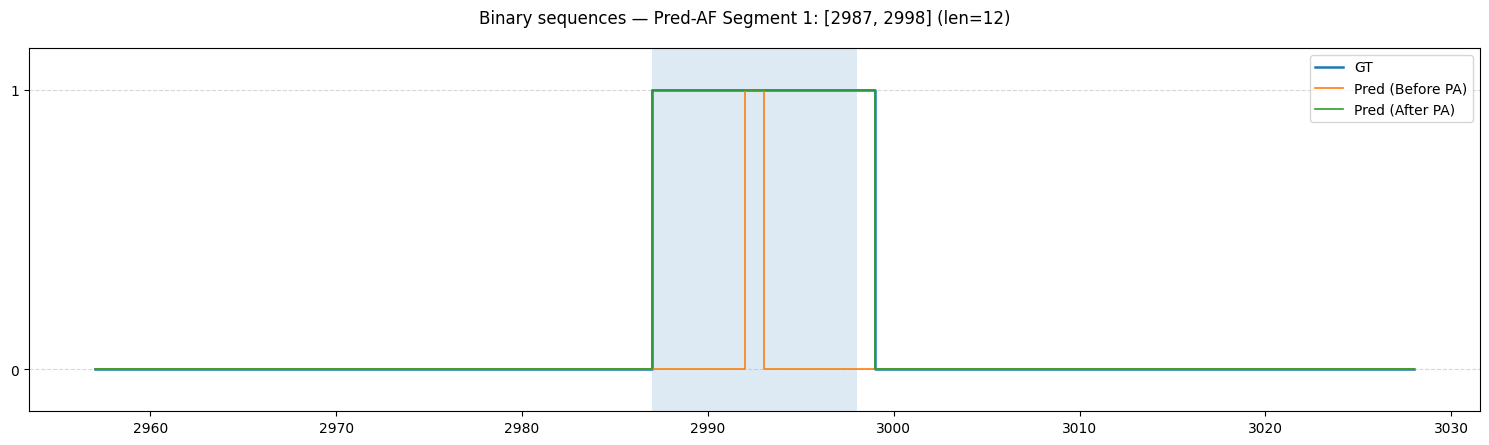

...........................................................


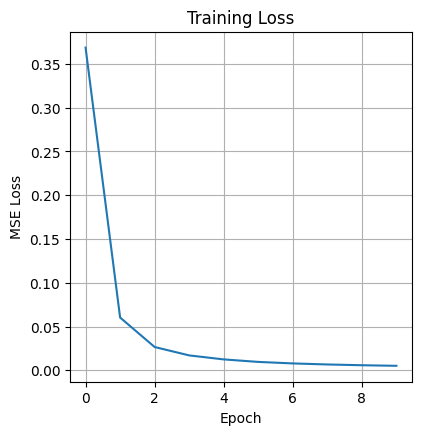

In [17]:
def main():
    set_seed(42, deterministic=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    data_path = "/kaggle/input/ucr-135"   
    batch_size = 32
    win_size = 100
    step = 1
    C = 1

    # UCR dataloader
    train_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=step, mode='train', dataset='UCR')
    test_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=win_size, mode='test', dataset='UCR')

    # PD dataloader
    #train_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=step, mode='train', dataset='PD')
    #test_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=win_size, mode='test', dataset='PD')

    # ECG dataloader
    #train_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=step, mode='train', dataset='ECG')
    #test_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=win_size, mode='test', dataset='ECG')

    # Gesture dataloader
    #train_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=step, mode='train', dataset='2DGesture')
    #test_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=win_size, mode='test', dataset='2DGesture')

    # MSL dataloader
    #train_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=step, mode='train', dataset='MSL')
    #test_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=win_size, mode='test', dataset='MSL')

    # SMD dataloader
    #train_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=step, mode='train', dataset='SMD')
    #test_loader = get_loader_segment(data_path, batch_size, win_size=win_size, step=win_size, mode='test', dataset='SMD')

    print("------------------------------------------------------------")
    print("Input shape train: ", next(iter(train_loader))[0].shape)
    print("Input shape test: ", next(iter(test_loader))[0].shape)
    print("Length of train loader: ", len(train_loader))
    print("Length of test loader: ", len(test_loader))
    print("------------------------------------------------------------")

    model = WaveletXAttnMulti(in_ch=C, d_model=64, nhead=4, dim_ff=128,
                              base=64, dec_depth=1, ad_weight=1.0,
                              loss_fn="mse", head='simple')

    model = model.to(device)

    print("Model Architecture: ")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

    # Training
    print("\nTraining.........................................")

    losses = train_model(model, train_loader, num_epochs=10, lr=1e-3, device=device)

    # Testing Phase
    print("\nTesting Phase............................................")
    model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

    best_f1, thr = test_with_percentile(model, test_loader, window=200, pad=20, device=device)

    print("...........................................................")

    # Plotting
    plt.figure(figsize=(15, 10))

    # Loss curve
    plt.subplot(2, 3, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)

if __name__ == "__main__":
    main()